In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# 1. 자이로스코프 데이터 로드 및 전처리
data = pd.read_csv('./원본 데이터/자이로 데이터.csv')

# 결측값 보간 처리
data['X'] = data['X'].interpolate()
data['Y'] = data['Y'].interpolate()
data['Z'] = data['Z'].interpolate()

# 2. 데이터 정규화
scaler = MinMaxScaler()
gyro_data = scaler.fit_transform(data[['X', 'Y', 'Z']])

# 3. K-Means 클러스터링 적용
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['cluster'] = kmeans.fit_predict(gyro_data)

# 슬라이딩 윈도우 함수 정의
def sliding_window(data, window_size, step_size):
    return [data[i:i + window_size] for i in range(0, len(data) - window_size + 1, step_size)]

sequence_length = 128
step_size = 10

# 4. 슬라이딩 윈도우 적용 (입력 시퀀스 생성)
gyro_sequences = sliding_window(gyro_data, sequence_length, step_size)
gyro_sequences = np.array(gyro_sequences)

# 클러스터 라벨도 슬라이딩 윈도우 적용
cluster_labels = sliding_window(data['cluster'].values, sequence_length, step_size)
cluster_labels = np.array(cluster_labels)

# 5. 데이터를 훈련용과 검증용으로 나누기 (80% 훈련, 20% 검증)
X_train, X_val, y_train, y_val = train_test_split(gyro_sequences, cluster_labels[:, 0], test_size=0.2, random_state=42)

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 텐서로 변환 및 GPU로 이동
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.long).to(device)

Using device: cpu


In [3]:
# 6. LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # 마지막 시퀀스의 출력만 사용
        return out, hidden
    
    def init_hidden(self, batch_size):
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)
        return (h_0, c_0)

# 모델 및 학습 설정
input_size = 3  # 자이로스코프 3축 데이터
hidden_size = 64  # LSTM hidden layer 크기
output_size = 6  # 예측 클래스 수 (K-means 클러스터 수)
num_layers = 1  # LSTM 레이어 수

model = LSTMModel(input_size, hidden_size, output_size, num_layers).to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. 검증 데이터 배치 처리 함수 정의
def evaluate_model(model, X_val, y_val, criterion, batch_size):
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for i in range(0, X_val.size(0), batch_size):
            batch_X_val = X_val[i:i + batch_size]
            batch_y_val = y_val[i:i + batch_size]

            # 배치 크기 확인 후 hidden state 초기화
            current_batch_size = batch_X_val.size(0)
            hidden = model.init_hidden(current_batch_size)  # 배치 크기에 맞게 hidden state 초기화

            outputs, hidden = model(batch_X_val, hidden)
            loss = criterion(outputs, batch_y_val)
            val_loss += loss.item()
            predicted_classes = torch.argmax(outputs, dim=1)
            val_correct += (predicted_classes == batch_y_val).sum().item()
            val_total += batch_y_val.size(0)

    val_accuracy = val_correct / val_total
    avg_val_loss = val_loss / val_total
    return avg_val_loss, val_accuracy

# 8. 모델 훈련 함수 정의
def train_model(model, X_train, y_train, X_val, y_val, criterion, optimizer, num_epochs, batch_size):
    for epoch in range(num_epochs):
        model.train()
        permutation = torch.randperm(X_train.size(0))
        epoch_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        # 배치별로 훈련
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_y = X_train[indices], y_train[indices]

            # 배치 크기 확인 후 hidden state 초기화
            current_batch_size = batch_X.size(0)
            hidden = model.init_hidden(current_batch_size)  # 배치 크기에 맞게 hidden state 초기화

            optimizer.zero_grad()

            # hidden state를 detach하여 그래프와의 연결을 끊음
            hidden = tuple([h.detach() for h in hidden])

            outputs, hidden = model(batch_X, hidden)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            predicted_classes = torch.argmax(outputs, dim=1)
            correct_predictions += (predicted_classes == batch_y).sum().item()
            total_predictions += batch_y.size(0)

        train_accuracy = correct_predictions / total_predictions
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(X_train):.4f}, Train Accuracy: {train_accuracy:.4f}")

        # 검증 데이터에 대한 평가
        val_loss, val_accuracy = evaluate_model(model, X_val, y_val, criterion, batch_size)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# 9. 모델 학습 시작
num_epochs = 50
batch_size = 32  # 배치 크기 설정

train_model(model, X_train, y_train, X_val, y_val, criterion, optimizer, num_epochs, batch_size)




Epoch [1/50], Loss: 0.0471, Train Accuracy: 0.4192
Validation Loss: 0.0265, Validation Accuracy: 0.6670
Epoch [2/50], Loss: 0.0217, Train Accuracy: 0.7260
Validation Loss: 0.0153, Validation Accuracy: 0.7929
Epoch [3/50], Loss: 0.0293, Train Accuracy: 0.6295
Validation Loss: 0.0114, Validation Accuracy: 0.8742
Epoch [4/50], Loss: 0.0111, Train Accuracy: 0.8758
Validation Loss: 0.0040, Validation Accuracy: 0.9496
Epoch [5/50], Loss: 0.0030, Train Accuracy: 0.9621
Validation Loss: 0.0024, Validation Accuracy: 0.9658
Epoch [6/50], Loss: 0.0022, Train Accuracy: 0.9711
Validation Loss: 0.0016, Validation Accuracy: 0.9764
Epoch [7/50], Loss: 0.0053, Train Accuracy: 0.9395
Validation Loss: 0.0030, Validation Accuracy: 0.9650
Epoch [8/50], Loss: 0.0023, Train Accuracy: 0.9702
Validation Loss: 0.0014, Validation Accuracy: 0.9814
Epoch [9/50], Loss: 0.0019, Train Accuracy: 0.9758
Validation Loss: 0.0016, Validation Accuracy: 0.9778
Epoch [10/50], Loss: 0.0046, Train Accuracy: 0.9525
Validation L

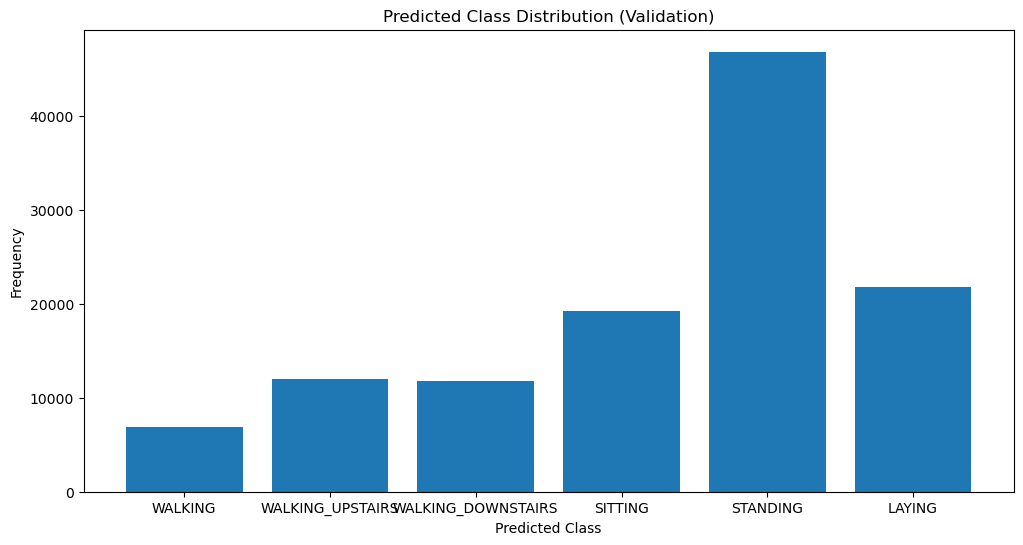

In [6]:
# 10. 예측된 행동 라벨로 변환 및 시각화
model.eval()
batch_size = 32  # 작은 배치 크기 설정 (예: 64)

all_predictions = []
with torch.no_grad():
    for i in range(0, X_val.size(0), batch_size):
        batch_X_val = X_val[i:i + batch_size]
        current_batch_size = batch_X_val.size(0)  # 현재 배치 크기를 사용
        hidden = model.init_hidden(current_batch_size)  # 배치 크기에 맞게 hidden state 초기화

        predictions, _ = model(batch_X_val, hidden)
        predicted_classes = torch.argmax(predictions, dim=1)
        all_predictions.append(predicted_classes)

# 배치별로 예측된 결과를 연결
all_predictions = torch.cat(all_predictions, dim=0)

LABELS = ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
predicted_labels = [LABELS[class_idx] for class_idx in all_predictions.cpu().numpy()]

# 시각화
plt.figure(figsize=(12, 6))
plt.hist(all_predictions.cpu().numpy(), bins=np.arange(len(LABELS) + 1) - 0.5, rwidth=0.8)
plt.title('Predicted Class Distribution (Validation)')
plt.xlabel('Predicted Class')
plt.ylabel('Frequency')
plt.xticks(np.arange(len(LABELS)), LABELS)
plt.show()